# Assess Masking

The goal of this notebook is to load in beh, spk and masking data to assess how much masking (0ing out of ephys data) is occuring on a per trial basis across a variety of sessions.

In [6]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import os
import sys; sys.path.insert(0, '..')
from utils import *

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def spks_dict_extract(spks_dict):
    """Function to help extract useful info from spks_dict that is nested deeply
    
    inputs
    ------
    spks_dict : dict, with spk info from .mat file
    
    returns
    -------
    spk2fsm    : arr, slope and y-int for getting from spike time to beh time
    trode_nums : list, what tetrode each cell is on in the session (1-32)
    fs         : int, sample rate of ephys
    """
    spk2fsm = spks_dict['behav_session'][0]['spk2fsm_rt'][0][0][0] #[m, b]
    
    trode_nums = []
    for i in range(len(spks_dict['trodenum'])):
        trode_nums.append(spks_dict['trodenum'][i][0][0])
        
    fs = spks_dict['fs'][0][0][0]
    
    return spk2fsm, trode_nums, fs

In [28]:
def load_masks(trode_nums, sess_dir):
    """Function for loading mask info stores in sortedd session direactory 
    based on the active tetrodes in the session
    
    inputs
    ------
    trode_num : list, what tetrode each cell is on in the session (1-32)
    sess_dir : path to directory for a sorted session with mask NPY files for each bundle
    
    returns
    -------
    mask_info : list, first item the list is unique trodes num list that is N long, remaining 
                N list items are masks for each unique tetrode (this needs to be modified for
                having multiple cells on the same bndl)
    """
    
    # intialize space
    
    mask_info = []
    
    # deal with multiple cells on one tetrode
    unique_trodes = np.unique(trode_nums)
    mask_info.append(unique_trodes)
    
    for trode in unique_trodes:
        
        # determine (unefficiently) which mask file is correct
        if trode <= 8:
            bndl = "bundle1_mask_info"
        elif trode > 8 <= 16:
            bndl = "bundle2_mask_info"
        elif trode > 16 <= 24:
            bndl = "bundle3_mask_info"
        elif trode > 24 <= 32:
            bndl = "bundle4_mask_info"
        else:
            print("trode not between 1-32, function will break")
            
        # load it, flatten & convert to bool (0.0 = noise, 1.0 = signal)
        bndl_mask = np.load(os.path.join(sess_dir, bndl))
        bndl_mask = bndl_mask.flatten()
        bndl_mask_bool = np.where(bndl_mask == 0.0, True, False) 
        mask_info.append(bndl_mask_bool)
        
    return mask_info

In [50]:
def mask2fsm(mask_info, fs, spk2fsm):
    
    """Quick function to use shape of boolean mask to create a second array in fsm time
    to allow for a common timeframe between task events and ephys masking"""
    
    # create a array the same length of the bool with values in seconds at fs
    mask_sec = np.linspace(0, len(mask_info[1])/fs, len(mask_info[1]))
    
    # convert the time array above from spk time to fsm time
    mask_fsm = (mask_sec * spk2fsm[0]) + spk2fsm[1]
    
    return mask_fsm

## I/O

In [185]:
# global
sess_name = 'W122_08_31_2019_1_fromSD' # this will be flexible
dir_name  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'
sess_dir = os.path.join(dir_name, sess_name)
save_path = "C:\\Users\\brodylab\\Documents\\GitHub\\jbreda_PWM_ephys_analysis\\masking_info\\figures"

# create paths
beh_path  = os.path.join(dir_name, sess_name, beh_mat)
spks_path = os.path.join(dir_name, sess_name, spks_mat)

# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=True)
spk2fsm, trode_nums, fs = spks_dict_extract(spks_dict)
mask_info = load_masks(trode_nums, sess_dir)
mask_beh_s = mask2fsm(mask_info, fs, spk2fsm)

In [72]:
no_viol_df = beh_df[beh_df['hit_hist'] != 'viol']
# save trial number, but reset the index
no_viol_df['trial_num'] = no_viol_df.index 
no_viol_df.index = range(len(no_viol_df))

c:\users\brodylab\anaconda3\envs\pwmephys\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [165]:
start = no_viol_df['c_poke']
end = no_viol_df['aud2_off']

trial_len = []
masked_trials =[]
num_masks = []


for tt in range(1, len(mask_info)):
    
    trial_len_tt = []
    masked_trials_tt = []
    num_masks_tt = []

   
    for trial in range(len(start)):

        idx_s = np.searchsorted(mask_beh_s, start[trial], side = "left")
        idx_e = np.searchsorted(mask_beh_s, end[trial], side = "left")

        trial_len_tt.append(idx_e - idx_s)
        masked_trials_tt.append(mask_info[tt][idx_s:idx_e])
        num_masks_tt.append(np.sum(mask_info[tt][idx_s:idx_e]))
    
    trial_len.append(trial_len_tt)
    masked_trials.append(masked_trials_tt)
    num_masks.append(num_masks_tt)


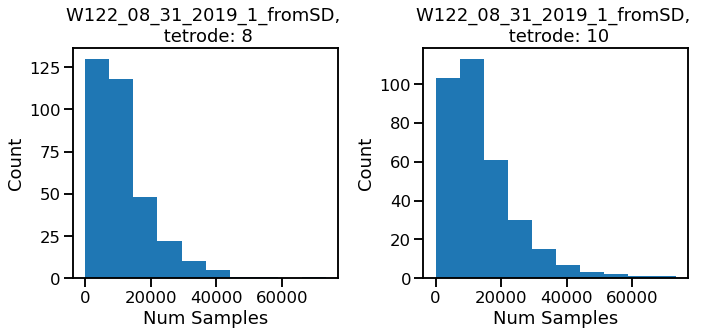

In [196]:
"Plot number of cut samples for each tetrode with cells"
plot_name = "{}_cut_samples.png".format(sess_name)
if len(trial_len) == 1:
    
    fig, ax = plt.subplots(1,1)
    ax.hist(num_masks[0])
    ax.set(ylabel = "Count", xlabel = "Num Samples")
    ax.set_title("{}, tetrode: {}".format(sess_name, mask_info[0][0]))
    
    plt.savefig(os.path.join(save_path, plot_name))

elif len(trial_len) > 1:
    fig,ax = plt.subplots(1, len(trial_len), figsize = (10,5))
    
    for tt in range(len(trial_len)):
        ax[tt].hist(num_masks[tt])
        ax[tt].set(ylabel = "Count", xlabel = "Num Samples")
        ax[tt].set_title("{}, \n tetrode: {}".format(sess_name, mask_info[0][tt]))
    plt.tight_layout()
    
    plt.savefig(os.path.join(save_path, plot_name))

#plt.close("all")

In [201]:
"""For each tetrode, on each trial, if less than 1000 samples were dropped,
get the idx of the trial (w/ respect to !=viol df)"""
n_samples = 1000
counter = []
good_idxs = []
for tt in range(len(num_masks)):
    count = 0
    idxs = [] 
    
    for trial in range(len(num_masks[tt])):
        if num_masks[tt][trial] < n_samples:
            count+=1
            idxs.append(trial)
    
    counter.append(count)
    good_idxs.append(idxs)
        

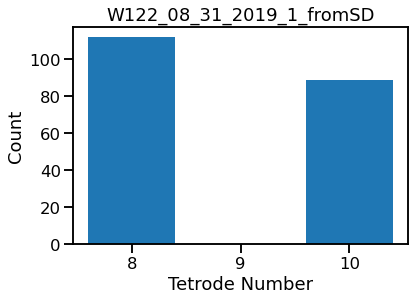

In [223]:
"Plot number of trials with less than 1000 samples cut by tetrode"
plot_name = "{}_n_good.png".format(sess_name)

    
fig, ax = plt.subplots(1,1)
ax.bar(mask_info[0], counter)
ax.set(ylabel = "Count", xlabel = "Tetrode Number")
ax.set_title("{}".format(sess_name))

plt.savefig(os.path.join(save_path, plot_name))

#plt.close("all")
    
    